<a href="https://colab.research.google.com/github/lokeshkumarn/Notebooks/blob/master/DL_MovieReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries/Dataset

### Import Libraries

In [ ]:
import time
import tensorflow as tf
from tensorflow.python.client import device_lib
from google.colab import drive

import pandas as pd
import numpy as np
import random as rd

from tensorflow import keras

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from matplotlib import pyplot as plt

In [ ]:
rd.seed(2020)         # Initialize the random number generator.
np.random.seed(2020)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(2020)  # sets the graph-level random seed

### Import Dataset

Load dataset from Google Drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset/IMDB Dataset.csv')

In [ ]:
df.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [ ]:
df.shape

(50000, 2)

### Check GPU

In [ ]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' ]

gpu_lst = get_available_gpus()

if(len(gpu_lst) > 0):
  print("GPU Enabled")

GPU Enabled


## Data Visualization

### Print Reviews

Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text

In [ ]:
print("Positive Reviews")
print("*"*30)
for i,r in df[df['sentiment'] =='positive'].reset_index()[:3].iterrows():
  print(i + 1,")",r['review'])
  print("\n")

print("Negative Reviews")
print("*"*30)
for i,r in df[df['sentiment'] =='negative'].reset_index()[:3].iterrows():
  print(i + 1,")",r['review'])
  print("\n")

Positive Reviews
******************************
1 ) One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I wou

### Plot Class Distribution

Plot a bar graph of class distribution in dataset. Each bar depicts the number of tweets belonging to a particular sentiment.

Text(0, 0.5, 'Sentiment')

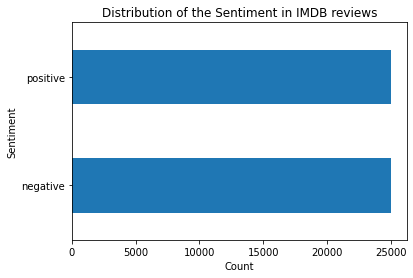

In [ ]:
ax = plt.subplot()
df['sentiment'].value_counts().plot(kind='barh',ax=ax)
ax.set_title("Distribution of the Sentiment in IMDB reviews")
ax.set_xlabel("Count")
ax.set_ylabel("Sentiment")

### Print the shapes of train and test data

In [ ]:
df['class'] = df['sentiment'].apply(lambda x:  1 if x=='positive' else 0)

In [ ]:
X = df['review'].values
y = df['class'].values
print(X.shape)
print(y.shape)

(50000,)
(50000,)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.3,
                                                 shuffle=True,
                                                 stratify=y,
                                                 random_state=2020)

In [ ]:
print('Train Features shape:',X_train.shape)
print('Test Features shape:',X_test.shape)
print('Train label shape:',y_train.shape)
print('Test label shape:',y_test.shape)

Train Features shape: (35000,)
Test Features shape: (15000,)
Train label shape: (35000,)
Test label shape: (15000,)


Text(0, 0.5, 'Sentiment')

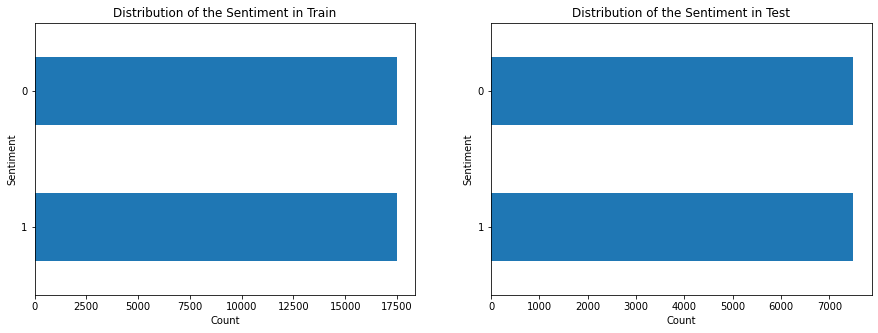

In [ ]:
#Verify whether stratification worked
fig,ax = plt.subplots(1,2,figsize=(15,5))
pd.Series(y_train).value_counts().plot(kind='barh',ax=ax[0])
pd.Series(y_test).value_counts().plot(kind='barh',ax=ax[1])
ax[0].set_title("Distribution of the Sentiment in Train")
ax[0].set_xlabel("Count")
ax[0].set_ylabel("Sentiment")
ax[1].set_title("Distribution of the Sentiment in Test")
ax[1].set_xlabel("Count")
ax[1].set_ylabel("Sentiment")

## Data Pre-processing

Need for this Step - Since the models we use cannot accept string inputs or cannot be of the string format. We have to come up with a way of handling this step.

Using the Pretrained embedding layer to convert the sentence to vector

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/1",output_shape=128,
                           input_shape=[], dtype=tf.string)

## Modeling

### Model Building

Sequential Model layers

In [ ]:
model = keras.Sequential()

1.   Add L2 regularization to all the layers.
2.   Add one layer of dropout at the appropriate position and give reasons.
3.   Choose the appropriate activation function for all the layers.

**Hidden Unit selection** are hyperparameters <br/>
For each parameter, decide a range and steps into that range, like 8 to 64 neurons, in powers of two (8, 16, 32, 64), and try each combination of the parameters. 

So I decided to reduce the number of parameters to learn as layers proceed, gave 64 and then **50% dropout** to further reduce the parameter to learn and also avoid overfitting, later 16 units to futher reduce the complexity of learning

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/1",output_shape=128,
                           input_shape=[], dtype=tf.string)

model = keras.Sequential()

model.add(hub_layer)

model.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01)) )

model.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01)))

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01)))

model.add(keras.layers.Dense(1, activation='sigmoid'))

Print the model summary

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 128)               249285376 
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 249,298,849
Trainable params: 13,473
Non-trainable params: 249,285,376
___________________________________

### Model Compilation

**Loss** : Binary Cross Entropy (because it's a binary classification problem <br/>
**Optimizer**: Adam  is an extension of the stochastic gradient descent and seen extensivelty used in Natural language processing. it has adaptive learning rate.
***Didn't choose a higher learning rate because wanted the network learn appropriately based on the distribution change in data***

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01,name='Adam'),#Use an appropriate optimizer
              loss='binary_crossentropy',#appropriate loss function
              metrics=['accuracy'])#Use accuracy as metric

### Model Training 

Train the model for an appropriate number of epochs (print the train and validation accuracy/loss for each epoch). Use the appropriate batch size

In [ ]:
start_train = time.time()
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=1000,
                    validation_split=0.2,
                    verbose=1)
end_train = time.time()

Epoch 1/50
28/28 [==============================] - 2s 58ms/step - loss: 1.0547 - accuracy: 0.6760 - val_loss: 0.6417 - val_accuracy: 0.7554
Epoch 2/50
28/28 [==============================] - 1s 52ms/step - loss: 0.5961 - accuracy: 0.7719 - val_loss: 0.5533 - val_accuracy: 0.7853
Epoch 3/50
28/28 [==============================] - 1s 53ms/step - loss: 0.5561 - accuracy: 0.7805 - val_loss: 0.5438 - val_accuracy: 0.7789
Epoch 4/50
28/28 [==============================] - 1s 52ms/step - loss: 0.5451 - accuracy: 0.7801 - val_loss: 0.5351 - val_accuracy: 0.7873
Epoch 5/50
28/28 [==============================] - 2s 54ms/step - loss: 0.5413 - accuracy: 0.7816 - val_loss: 0.5327 - val_accuracy: 0.7789
Epoch 6/50
28/28 [==============================] - 1s 53ms/step - loss: 0.5355 - accuracy: 0.7819 - val_loss: 0.5305 - val_accuracy: 0.7777
Epoch 7/50
28/28 [==============================] - 1s 52ms/step - loss: 0.5470 - accuracy: 0.7730 - val_loss: 0.5277 - val_accuracy: 0.7850
Epoch 8/50
28

Plot the loss and accuracy history graphs

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fix,ax = plt.subplots(1,2, figsize=(15,5))
ax1 = ax[0] # to plot Training Loss
ax2 = ax[1] # to plot Training Accuracy

ax1.plot(epochs, loss, 'b', label='Training loss')# "bo" is for "blue dot"
ax1.plot(epochs, val_loss, 'r', label='Validation loss')# b is for "solid blue line"
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, 'b', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
#Time taken to train
print("Time taken to train the NN:",end_train - start_train," seconds")

Time taken to train the NN: 77.25413489341736  seconds


### Model Evaluation

Print the final test/validation loss and accuracy

In [ ]:
results = model.evaluate(X_test, y_test)

print("Test Loss:",results[0])
print("Test Accuracy:",results[1])

469/469 [==============================] - 2s 5ms/step - loss: 0.4921 - accuracy: 0.7919
Test Loss: 0.49208223819732666
Test Accuracy: 0.791866660118103


In [ ]:
#Predictions
y_pred = model.predict_classes(X_test)

Confusion Matrix

In [ ]:
print("Confustion Matrix")
print(confusion_matrix(y_test,y_pred))

Confustion Matrix
[[6451 1049]
 [2073 5427]]


In [ ]:
y_pred = [v[0] for v in y_pred]

In [ ]:
df = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
df.head()
confusion_matrix = pd.crosstab(df['y_test'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted     0     1
Actual               
0          6451  1049
1          2073  5427


Classification Report

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      7500
           1       0.81      0.77      0.79      7500

    accuracy                           0.80     15000
   macro avg       0.80      0.80      0.80     15000
weighted avg       0.80      0.80      0.80     15000



**Write a summary for the best and worst performing class and the overall trend??**

Worst performing class is postive class because compared to the negative sentiment most of the positive sentiment is predicted incorrectly by the model. <br/>
In the first 10 epochs itself model was able to acheive the accuracy of 77+, however still continue to train for 50 epochs ,we haven't introduced the callbacks like early stopping to stop the train if score doesn't improve much.

We will try to move the Drop out to different position and will reduce or increase the batch size in the subsequent trainings